In [6]:
import pandas as pd

In [2]:
candidates = pd.read_csv('./datas/candidate_items.csv')
candidates

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


In [70]:
items = pd.read_csv('./datas/item_features.csv')
items

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


In [4]:
from datetime import datetime


def dateparse(date):    
    return int(datetime.strptime(date.split('.')[0], '%Y-%m-%d  %H:%M:%S').timestamp())

train_purchases = pd.read_csv('./datas/train_purchases.csv', parse_dates=[2])

# train_purchases['ts'] = train_purchases['date'].astype('int64')
train_purchases

NameError: name 'pd' is not defined

In [7]:
train_sessions = pd.read_csv('./datas/train_sessions.csv', parse_dates=[2])
train_sessions

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


In [7]:
test_leaderboard_sessions = pd.read_csv('./datas/test_leaderboard_sessions.csv')
test_leaderboard_sessions

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# Embedding items
Items are represented in a sparse format with the id of the feature and its value. We have no information on whether or not it is categorical or numerical, or the number of features. We want to explore them a little bit and find a compact representation.

First we want to know the coverage of each feature. Do a plot with, in x-axis, the feature id, and in y-axis, the number of non-null values.

<BarContainer object of 73 artists>

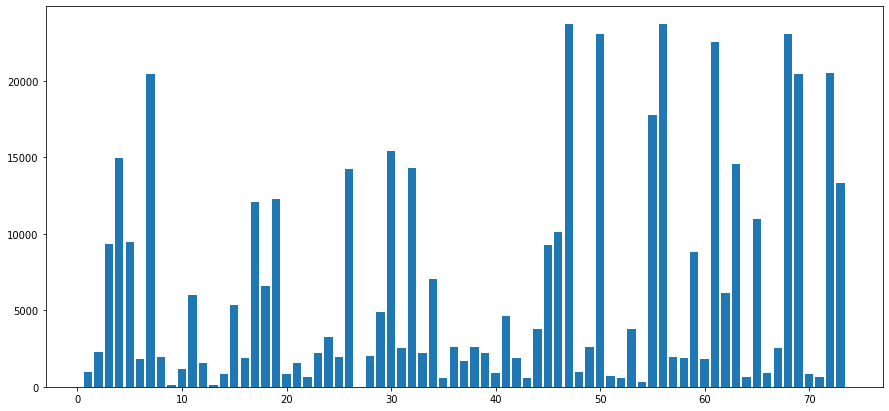

In [32]:
from matplotlib import pyplot as plt

features_id_counts = items.groupby(["feature_category_id"])["feature_category_id"].count()

plt.figure(figsize=(15,7))
plt.bar(features_id_counts.index, features_id_counts)

73 features is not that much, let's see how each of them look. Display the counts / min / max / std for each feature. You should see that one feature is useless, remove it!

In [56]:
items.groupby("feature_category_id")["feature_value_id"].describe().sort_values(by=["count"])

,count,mean,std,min,25%,50%,75%,max
feature_category_id,,,,,,,,
27,1.0,423.000000,NaN,423.0,423.0,423.0,423.0,423.0
9,137.0,223.635036,77.537171,175.0,175.0,190.0,190.0,369.0
13,137.0,580.554745,206.876701,252.0,252.0,698.0,698.0,905.0
54,341.0,760.448680,101.582889,197.0,785.0,785.0,785.0,785.0
52,568.0,551.839789,223.219225,227.0,293.0,728.0,756.0,756.0
...,...,...,...,...,...,...,...,...
61,22512.0,676.885528,154.116169,59.0,706.0,706.0,706.0,898.0
68,23038.0,443.496050,230.800434,10.0,351.0,373.0,702.0,903.0
50,23077.0,483.046757,285.430458,8.0,240.0,328.0,708.0,901.0


If 73 features is not a lot, it is still a big number given the number of samples for your poor laptop if you make it dense. It is also good practice to preprocess the data into a set of embeddings without sparse format because most ML algorithm do not handle sparse. We want to do it now. Use TruncatedSVD from scikit-learn with n_components = 12 (or less depending on your memory) and compute embeddings for your items.

In [90]:
import numpy as np
from scipy.sparse import coo_matrix

s_items = coo_matrix((items["feature_value_id"], (items["item_id"], items["feature_category_id"])))
s_items

<28144x74 sparse matrix of type '<class 'numpy.int64'>'
	with 471751 stored elements in COOrdinate format>

In [96]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=12)
svd.fit(s_items)
df = svd.transform(s_items)
df.shape

(28144, 12)

You now have a matrix of dimension (28144, n_components) representing the items.

In [97]:
df = pd.DataFrame(df)
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,794.680184,377.343644,-303.561657,669.612890,487.115149,31.156923,179.043555,297.292026,-153.167228,-448.937859,-82.791196,43.710547
3,2387.218101,-924.921011,161.342828,-448.550064,-36.610185,-508.699049,-261.135951,140.716734,-136.533737,-86.432806,102.639425,-516.299068
4,2304.639154,-837.402436,194.342670,-143.934254,-183.789264,3.291285,190.627623,-170.633565,-157.210085,-63.217453,-371.794494,53.975370
...,...,...,...,...,...,...,...,...,...,...,...,...
28139,2496.719059,-681.709968,127.865506,94.363965,-141.323320,830.511271,-244.854159,-96.671582,367.022462,38.415956,-407.839838,-30.549094
28140,747.063373,532.023461,-1458.557353,-589.887965,-396.119731,6.410072,44.172638,-82.456460,-223.151233,-183.487050,80.403775,-77.970060
28141,2039.201872,-664.322599,27.056823,-712.698209,16.570828,17.029206,252.157055,-164.868439,-58.295237,-299.229741,-75.100769,-141.445151
28142,1472.569195,356.499022,-347.940107,38.524871,879.685978,493.890754,56.292978,12.004946,227.327803,-35.775564,-237.300876,-304.067380


# Embedding sessions

Sessions are defined by a series of items, we first want to see what they look like to be able to find a suitable representation for them.

My advice: start by sampling the train_sessions dataframe to keep 5% or 10% otherwise your memory may suffer.

Then plot the distribution of session sizes: x-axis is the size of the session, y-axis is the number of sessions of this size. Determine a threshold to contain completely 90% of the sessions. This is how we will compute the session representation.

In [8]:
sample = train_session.sample(frac=0.05, random_state=42)

sessions_size = sample.groupby("session_id")["session_id"].count()

sample

NameError: name 'train_session' is not defined

Let $k$ be the length you have picked for your session. Create a vectorize representation of your sessions by either concatenating the embedding of the corresponding items, or averaging them (if memory is scarse).

In [19]:
sample.columns = sample.columns.to_flat_index()
sample

,"(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)","(0, 10)",...,"(11, 1)","(11, 2)","(11, 3)","(11, 4)","(11, 5)","(11, 6)","(11, 7)","(11, 8)","(11, 9)","(11, 10)"
session_id,,,,,,,,,,,,,,,,,,,,,
3,785.516809,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-86.202978,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,2481.349708,2486.438679,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-178.053272,-112.179836,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,1733.407766,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,96.668959,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,2467.343275,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-127.570648,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,1121.288268,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-39.133408,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439954,2395.573998,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-21.271005,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4439968,1221.231491,2559.844559,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,282.769979,264.369360,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4439973,2403.198930,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62.288767,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Embedding purchases
Purchases are one item, so we simply use their embedding. However, we also need to add negative samples so that our model not only learn on positives (One class SVM can do this, but those models are not known to generalize well...). In order to generate negative samples, shuffle the item_id columns of 4 copies of the purchase array. The original values have a label 1, the copies that have been shuffled have a value of 0.

In [25]:
all_purchases = df.merge(all_purchases, right_on='item_id', left_index=True).drop('item_id', axis=1)
all_purchases

,0,1,2,3,4,5,6,7,8,9,10,11,session_id,y
38061,2387.218101,-924.921011,161.342827,-448.550069,-36.609986,-508.694622,-261.139698,140.682276,-136.612030,-86.578763,102.873067,-517.915449,169632,1
41931,2387.218101,-924.921011,161.342827,-448.550069,-36.609986,-508.694622,-261.139698,140.682276,-136.612030,-86.578763,102.873067,-517.915449,186292,1
89368,2387.218101,-924.921011,161.342827,-448.550069,-36.609986,-508.694622,-261.139698,140.682276,-136.612030,-86.578763,102.873067,-517.915449,399081,1
181165,2387.218101,-924.921011,161.342827,-448.550069,-36.609986,-508.694622,-261.139698,140.682276,-136.612030,-86.578763,102.873067,-517.915449,807144,1
213634,2387.218101,-924.921011,161.342827,-448.550069,-36.609986,-508.694622,-261.139698,140.682276,-136.612030,-86.578763,102.873067,-517.915449,951781,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229410,1416.456714,285.630602,-353.123134,-233.109374,1079.421740,34.144750,-404.359121,-80.036616,-131.602859,200.627505,-32.116068,371.320120,1021853,0
4456575,1416.456714,285.630602,-353.123134,-233.109374,1079.421740,34.144750,-404.359121,-80.036616,-131.602859,200.627505,-32.116068,371.320120,2029338,0
4477724,1416.456714,285.630602,-353.123134,-233.109374,1079.421740,34.144750,-404.359121,-80.036616,-131.602859,200.627505,-32.116068,371.320120,2121839,0
4495127,1416.456714,285.630602,-353.123134,-233.109374,1079.421740,34.144750,-404.359121,-80.036616,-131.602859,200.627505,-32.116068,371.320120,2198365,0


In [26]:
del train_purchases, negative_train_purchases

# Merge everything

We merge the whole dataset together to fit a model. For each session we concatenate:
* The history of the user
* The purchase embedding, with the label

We will have our training set!

# Learn a model and predict on test

This is it. You have now a dataset that you can directly pass to a LogisticRegression. For the testing part, perform your prediction on all candidates and pick the hundred ones that have the highest results.

# Going further

Your next task is to have an RNN running on this dataset. Take a look at [this notebook](https://github.com/oakfr/intro-to-reco/blob/master/application/part_2/RNN-next-item-prediction.ipynb) and adapt it to your usecase!

You are now ready to start the project. Take a look at the packages [surprise](http://surpriselib.com/) and [Microsoft recommenders](https://github.com/microsoft/recommenders) to find models available out of the box.